In [1]:
import sys

sys.path.append("xai-ranking-benchmark")

import numpy as np
import pandas as pd
from lightgbm import LGBMRanker
from xgboost import XGBRanker
from sharp import ShaRP
from sharp.metrics import (
    outcome_fidelity, 
    kendall_agreement, 
    jaccard_agreement, 
    euclidean_agreement
)
from sharp.utils import scores_to_ordering
from xai_ranking.preprocessing import (
    preprocess_movers_data,
)
from xai_ranking.datasets import (
    fetch_movers_data,
)
from mlresearch.utils import set_matplotlib_style

RNG_SEED = 42
FAIR_MOVERS = "fair"

In [2]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(
    fetch_movers_data(test=False, fair=FAIR_MOVERS)
)
qids_train = X.index.value_counts().to_numpy()

In [3]:
# LGBM Ranker
lgbm = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
lgbm.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

# XGB Ranker
xgb = XGBRanker(tree_method="hist", lambdarank_num_pair_per_sample=8, objective="rank:pairwise", lambdarank_pair_method="topk")
xgb.fit(
    X=X, 
    y=ranks,
    group=qids_train,
)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=8, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

In [4]:
X_test, ranks, scores = preprocess_movers_data(fetch_movers_data(test=True, fair=FAIR_MOVERS))
xgb_ranks = scores_to_ordering(xgb.predict(X_test), 1)
lgbm_ranks = scores_to_ordering(lgbm.predict(X_test), 1)

In [5]:
xgb_xai = ShaRP(
    qoi="rank", 
    target_function=xgb.predict, 
    measure="shapley", 
    sample_size=10, 
    random_state=RNG_SEED,
    verbose=1
)
xgb_xai.fit(X_test)

lgbm_xai = ShaRP(
    qoi="rank", 
    target_function=lgbm.predict, 
    measure="shapley", 
    sample_size=10, 
    random_state=RNG_SEED,
    verbose=1
)
lgbm_xai.fit(X_test)

In [6]:
# Get a sample of points, 10 from each rank stratum
# X_test, ranks, scores
rng = np.random.default_rng(RNG_SEED)
n_samples_total = 100
n_bins = 10
bins = np.linspace(0, ranks.max()+1, n_bins+1)
strata = np.digitize(ranks, bins)

n_samples_bin = int(np.round((n_samples_total / n_bins)))
indices = []
for i in np.unique(strata):
    ids_ = np.where(strata==i)[0].tolist()
    ids_ = rng.choice(ids_, n_samples_bin)
    indices += ids_.tolist()

indices = np.array(indices)

In [7]:
xgb_contributions = pd.DataFrame(xgb_xai.all(X_test.iloc[indices]), columns=X_test.columns, index=X_test.iloc[indices].index)
lgbm_contributions = pd.DataFrame(lgbm_xai.all(X_test.iloc[indices]), columns=X_test.columns, index=X_test.iloc[indices].index)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: >

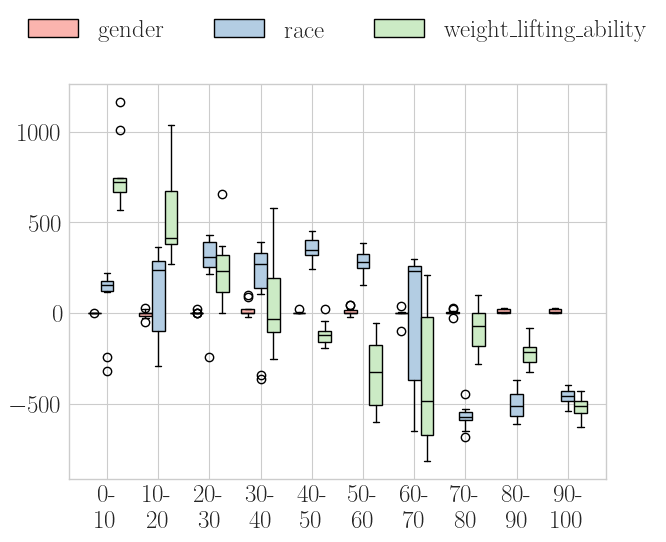

In [8]:
set_matplotlib_style(18)
xgb_xai.plot.box(X_test.iloc[indices], xgb_ranks[indices], xgb_contributions, feature_names=X_test.columns, group=10)

<Axes: >

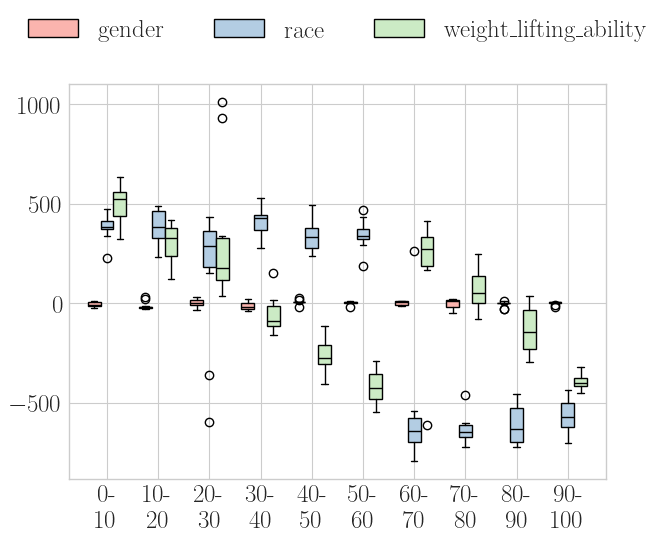

In [9]:
lgbm_xai.plot.box(X_test.iloc[indices], lgbm_ranks[indices], lgbm_contributions, feature_names=X_test.columns, group=10)

# Tests

In [16]:
euc = euclidean_agreement(lgbm_contributions, xgb_contributions, normalization=True)
ken = kendall_agreement(lgbm_contributions, xgb_contributions)
jac = jaccard_agreement(lgbm_contributions, xgb_contributions, n_features=1)
fid_lgbm = outcome_fidelity(lgbm_contributions, ranks[:100], ranks.mean(), ranks.max())
fid_xgb = outcome_fidelity(xgb_contributions, ranks[:100], ranks.mean(), ranks.max())

In [17]:
lgbm_contributions, xgb_contributions

(         gender        race  weight_lifting_ability
 qid                                                
 2    393.100000  212.850000             -352.333333
 2    410.783333  241.100000             -295.750000
 2    309.233333  246.233333             -360.850000
 2    222.233333  165.866667             -471.466667
 2    307.666667 -550.066667             -246.800000
 ..          ...         ...                     ...
 2   -732.616667  286.266667              438.100000
 2   -633.283333  417.400000              488.033333
 2    300.800000  196.650000              399.733333
 2   -318.883333   92.216667             1242.183333
 2    182.983333  160.216667              755.833333
 
 [100 rows x 3 columns],
        gender        race  weight_lifting_ability
 qid                                              
 2    0.000000  251.466667             -230.283333
 2    0.000000  299.933333             -211.600000
 2    0.000000  269.866667             -286.283333
 2    0.000000  240.650000   

In [18]:
outcome_fidelity(xgb_contributions, ranks[:100], ranks.mean(), ranks.max())

np.float64(0.6264545000000001)

In [19]:
ranks[:100]

array([ 528,  818, 1859, 1869, 1665,  155,  182,  497, 1119,  147,  927,
       1216,  293,  161, 1323, 1076, 1672,   50,   70,  987, 1034,  576,
        372,  575,  191, 1453, 1434,   13, 1667,  786,  547,  603,  586,
         75,  138, 1161,  685,  644,   33, 1201,   37, 1020, 1211, 1519,
        544,  549,  361, 1548, 1721, 1422,  636,  118,  484,  256,  858,
          1, 1826,  589, 1696,  205, 1704,  803, 1143, 1606,    4, 1524,
         52,  879,  532, 1571,  994, 1931, 1552, 1944, 1087,  829, 1443,
        652,  280, 1270,  742,  332, 1483, 1378,  582, 1948, 1464, 1082,
        773, 1231, 1785, 1751,  831,  224, 1396, 1642, 1055, 1144, 1159,
        420])